In [1]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import itertools
import pickle
import random

from PIL import Image
from scipy import interp
from random import randint
from sklearn import metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras import callbacks
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy
from keras.models import model_from_json, Model, Sequential
from keras.optimizers import *

from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.regularizers import l2
from keras.utils.data_utils import Sequence

Using TensorFlow backend.


In [2]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

simple_model_epochs = 40
simple_model_bs = 32



In [3]:
filname = 'fer2013/fer2013.csv'
names = ['emotion','pixels','usage']
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(label_map)

df = pd.read_csv('fer2013/fer2013.csv', names=names, na_filter=False)
im = df['pixels']

def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

X, Y = getData(filname)
num_class = len(set(Y))
X = X * 255

N, D = X.shape
X = X.reshape(N, 48, 48, 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

y_train_flat = y_train
y_test_flat = y_test

y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

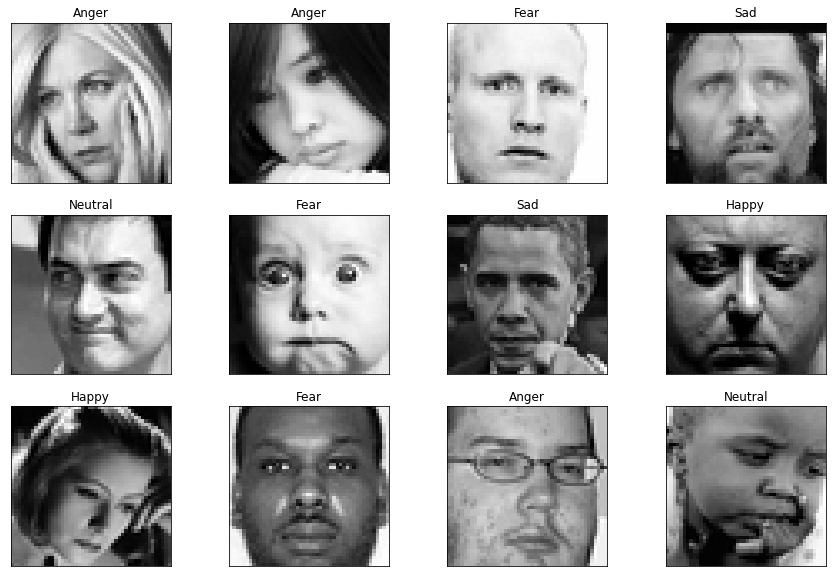

In [4]:
fig = plt.figure(figsize = (15, 10))

for counter, img in enumerate(X_train[:12]):
    ax = fig.add_subplot(3, 4, counter + 1)
    ax.imshow(np.asarray(X_train[counter]).reshape(48, 48), cmap = 'gray')
    plt.title(label_map[Y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.show()

In [5]:
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

datagen.fit(X_train)

In [6]:
def plot_confusion_matrix(y_test, 
                          y_pred,
                          title='Unnormalized confusion matrix'):
    
    classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
    
    cmap=plt.cm.Blues
    cm = confusion_matrix(y_test, y_pred)
    
    # if normalize:
        # cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
    #plt.savefig(title + '.png')
    
def randomColorGenerator(number_of_colors = 1, seed = 0):
    '''Generate list of random colors'''
    np.random.seed(seed)
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(number_of_colors)]

def make_fpr_tpr_auc_dicts(y, probs_list):
    '''Compute and return the ROC curve and ROC area for each class in dictionaries'''
    # Dicts
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    
    # For test
    for i in range(num_classes):
        fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y[:, i], probs_list[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), probs_list.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= num_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

def plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001), seed=0, save_title=None):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,5))
    
    lw = 2
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    
    if num_classes!=4:
        class_colors = randomColorGenerator(num_classes, seed)
    
    for i in range(num_classes):
        axes[0].plot(fpr[i], tpr[i], color=class_colors[i], label='{0} ({1:0.2f}%)' ''.format(label_map[i], roc_auc[i]*100))
        axes[1].plot(fpr[i], tpr[i], color=class_colors[i], lw=lw, label='{0} ({1:0.2f}%)' ''.format(label_map[i], roc_auc[i]*100))
    
    axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg ({:0.2f}%)' ''.format(roc_auc['micro']*100), linestyle=':', color='deeppink')
    axes[0].plot(fpr['macro'], tpr['macro'], label='Macro avg ({:0.2f}%)' ''.format(roc_auc['macro']*100), linestyle=':', color='navy')
    axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[0].scatter(0,1, label='Ideal', s=2)
    
    axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg ({:0.2f}%)'.format(roc_auc['micro']*100), linestyle=':', color='deeppink')
    axes[1].plot(fpr['macro'], tpr['macro'], lw=lw, label='Macro avg ({:0.2f}%)'.format(roc_auc['macro']*100), linestyle=':', color='navy')
    axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[1].scatter(0,1, label='Ideal', s=50)
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    
    axes[0].grid(True, linestyle='dotted', alpha=1)
    axes[1].grid(True, linestyle='dotted', alpha=1)
    
    axes[0].legend(loc=4)
    axes[1].legend(loc=4)
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

# DEFINE MODELS

In [7]:
### SIMPLE MODEL

def simple_model():
    input_shape = (48,48,1)
    simple_model = Sequential()
    simple_model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    simple_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    simple_model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    simple_model.add(Activation('relu'))
    simple_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    simple_model.add(Conv2D(64, (3, 3), activation = 'relu'))
    simple_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    simple_model.add(Flatten())
    simple_model.add(Dense(128, activation = 'relu'))
    simple_model.add(Dropout(0.5))
    
    simple_model.add(Dense(7, activation = 'softmax'))
    
    simple_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='RMSprop')

    return simple_model

# SIMPLE MODEL

In [9]:
### SIMPLE MODEL - FIT

path_model='simple_model.h5'
simple_model=simple_model()

# K.tensorflow_backend.clear_session()
# with tpu_strategy.scope():
simple_model_result = simple_model.fit_generator(datagen.flow(X_train, y_train, batch_size = simple_model_bs),
                                                     validation_data = (X_test, y_test),
                                                     epochs = simple_model_epochs,
                                                     # steps_per_epoch = 4096,
                                                     verbose = 1,
                                                     callbacks = [ModelCheckpoint(filepath = path_model)])

# Save trained model to disk
filename = 'trained_simple_model.sav'
pickle.dump(simple_model_result, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

simple_model_scores = simple_model.evaluate(X_test, y_test, verbose=1)
print('Simple Model Test Loss:', simple_model_scores[0])
print('Simple Model Test Accuracy:', simple_model_scores[1])

Epoch 1/40
898/898 [==============================] - 14s 16ms/step - loss: 1.8949 - accuracy: 0.2596 - val_loss: 1.6859 - val_accuracy: 0.3318
Epoch 2/40
898/898 [==============================] - 12s 13ms/step - loss: 1.6931 - accuracy: 0.3350 - val_loss: 1.6050 - val_accuracy: 0.3752
Epoch 3/40
898/898 [==============================] - 12s 13ms/step - loss: 1.6433 - accuracy: 0.3619 - val_loss: 1.5368 - val_accuracy: 0.4071
Epoch 4/40
898/898 [==============================] - 11s 13ms/step - loss: 1.6108 - accuracy: 0.3770 - val_loss: 1.5163 - val_accuracy: 0.4182
Epoch 5/40
898/898 [==============================] - 13s 14ms/step - loss: 1.6015 - accuracy: 0.3802 - val_loss: 1.5053 - val_accuracy: 0.4227
Epoch 6/40
898/898 [==============================] - 12s 13ms/step - loss: 1.5947 - accuracy: 0.3874 - val_loss: 1.6538 - val_accuracy: 0.3867
Epoch 7/40
898/898 [==============================] - 12s 14ms/step - loss: 1.5897 - accuracy: 0.3874 - val_loss: 1.5091 - val_accuracy:

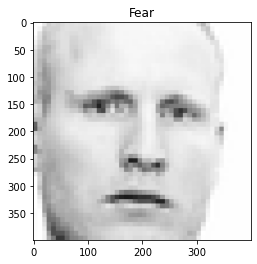

In [10]:
rnd = random.randint(0, X_train.shape[0])
rnd = 2
s1 = np.array(X_train[rnd].reshape(48, 48))
img = Image.fromarray(s1)
img = img.resize((400,400))

plt.title(label_map[Y[rnd]])
plt.imshow(img)

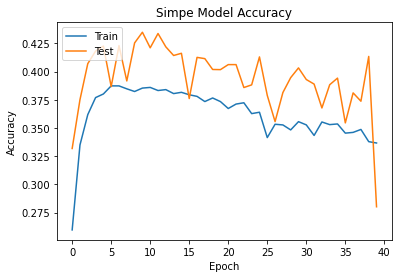

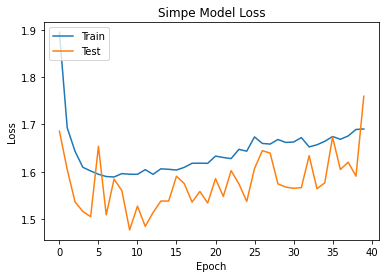

7178/7178 [==============================] - 0s 48us/step


<Figure size 432x288 with 0 Axes>

In [11]:
### SIMPLE MODEL - PLOTS

plt.plot(simple_model_result.history['accuracy'])
plt.plot(simple_model_result.history['val_accuracy'])
plt.title('Simpe Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('Simpe Model Accuracy.png')

plt.plot(simple_model_result.history['loss'])
plt.plot(simple_model_result.history['val_loss'])
plt.title('Simpe Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('Simpe Model Loss.png')

simple_model_y_pred_ = simple_model.predict(X_test, verbose=1)
simple_model_y_pred = np.argmax(simple_model_y_pred_, axis=1)
simple_model_t_te = np.argmax(y_test, axis=1)

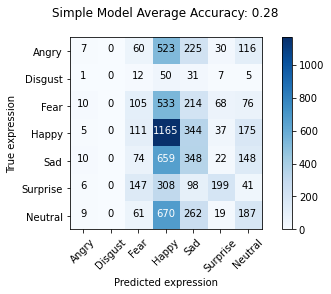

<Figure size 432x288 with 0 Axes>

In [12]:
### SIMPLE MODEL - PLOTS

fig = plot_confusion_matrix(y_test=simple_model_t_te,
                            y_pred=simple_model_y_pred,
                            title='Simple Model Average Accuracy: ' + str(round(np.sum(simple_model_y_pred == simple_model_t_te)/len(simple_model_t_te), 2)) + '\n')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


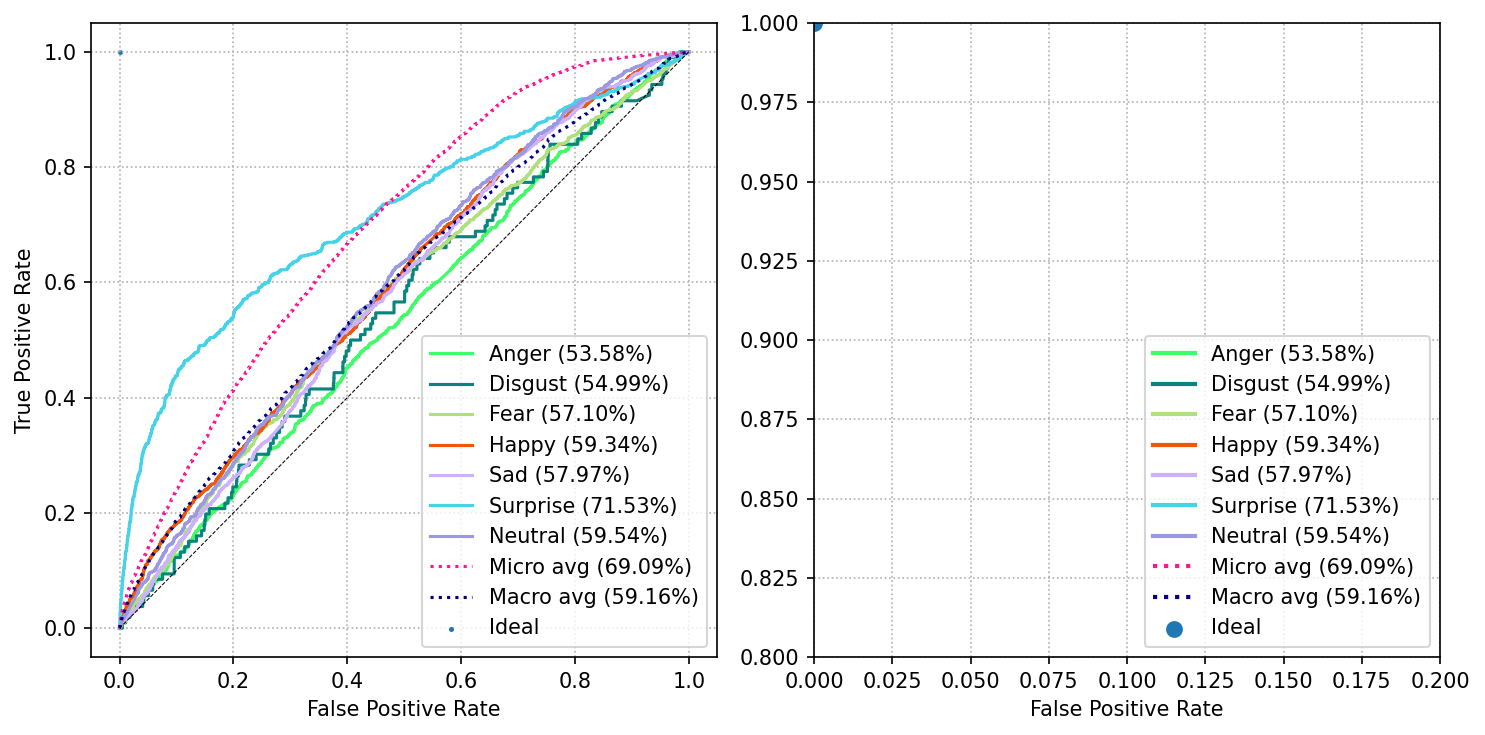

In [13]:
### SIMPLE MODEL - PLOTS

fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(y_test, simple_model_y_pred_)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 0.2), ylim=(0.8, 1), seed=5, save_title='Simple: ROC')